<a href="https://colab.research.google.com/github/jadechip/on-chain-analytics-lstm/blob/master/metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import io
import json
import requests
import functools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

pd.options.mode.chained_assignment = None

## Bitcoin price

In [0]:
def make_request(url, *args):
  print(url(*args))
  return requests.get(url(*args))

In [0]:
start      = 20100718
end        = 20180429
params     = "PriceUSD"
url        = lambda params: f"https://community-api.coinmetrics.io/v2/assets/btc/metricdata?metrics={params}&start={start}&end={end}"

In [6]:
response = make_request(url, "PriceUSD")

https://community-api.coinmetrics.io/v2/assets/btc/metricdata?metrics=PriceUSD&start=20100718&end=20180429


In [0]:
json = response.json()

In [0]:
price_df = pd.DataFrame(json["metricData"]["series"])
price_df["values"] = price_df["values"].apply(lambda x: x[0])
price_df["values"] = price_df["values"].astype(float)

In [0]:
price_df['time'] = pd.to_datetime(price_df['time'])
price_df['time'] = price_df['time'].dt.strftime('%d-%m-%Y')

In [10]:
price_df.head()

,time,values
0,18-07-2010,0.085840
1,19-07-2010,0.080800
2,20-07-2010,0.074736
3,21-07-2010,0.079193
4,22-07-2010,0.058470


## Metrics

In [0]:
start      = 1279324800
end        = 1524960000
metrics_df = pd.DataFrame()
api_key    = "5a0cf8d7-d14a-44f4-b063-a76807cd5340"
base       = "https://api.glassnode.com/v1"
url        = lambda api_key: f"{endpoint}?api_key={api_key}&a=BTC&s={start}&u={end}"
endpoints  = {
  "dormancy" : f"{base}/metrics/indicators/average_dormancy",
  "velocity" : f"{base}/metrics/indicators/velocity",
  "nvts"     : f"{base}/metrics/indicators/nvts",
  "sopr"     : f"{base}/metrics/indicators/sopr",
  "mvrv"     : f"{base}/metrics/market/mvrv" 
}

In [12]:
for name, endpoint in endpoints.items():
  response = make_request(url, api_key)
  tmp = pd.read_json(response.content, convert_dates=["t"], date_unit="s")
  tmp.columns = ["date", name]
  diff = tmp.columns.difference(metrics_df.columns)
  metrics_df = pd.concat([metrics_df, tmp[diff]], axis=1, sort=False)

https://api.glassnode.com/v1/metrics/indicators/average_dormancy?api_key=5a0cf8d7-d14a-44f4-b063-a76807cd5340&a=BTC&s=1279324800&u=1524960000
https://api.glassnode.com/v1/metrics/indicators/velocity?api_key=5a0cf8d7-d14a-44f4-b063-a76807cd5340&a=BTC&s=1279324800&u=1524960000
https://api.glassnode.com/v1/metrics/indicators/nvts?api_key=5a0cf8d7-d14a-44f4-b063-a76807cd5340&a=BTC&s=1279324800&u=1524960000
https://api.glassnode.com/v1/metrics/indicators/sopr?api_key=5a0cf8d7-d14a-44f4-b063-a76807cd5340&a=BTC&s=1279324800&u=1524960000
https://api.glassnode.com/v1/metrics/market/mvrv?api_key=5a0cf8d7-d14a-44f4-b063-a76807cd5340&a=BTC&s=1279324800&u=1524960000


### Join

In [0]:
metrics_df["target_price"] = price_df["values"]

In [0]:
metrics_df = metrics_df.set_index("date", drop=True)

In [15]:
metrics_df.head()

,dormancy,velocity,nvts,sopr,mvrv,target_price
date,,,,,,
2010-07-17,17.557391,0.009522,50.456801,1.000000,1.000000,0.085840
2010-07-18,37.898148,0.012926,65.719591,1.174760,1.299792,0.080800
2010-07-19,8.009980,0.016157,91.505617,1.318536,1.813274,0.074736
2010-07-20,2.325436,0.011241,79.848213,1.090517,1.584801,0.079193
2010-07-21,23.594423,0.010933,70.508828,1.065532,1.398245,0.058470


### Test-Training split

In [16]:
training_data, testing_data = train_test_split(metrics_df, test_size=0.2, shuffle=False)
print(f"Training data size: {training_data.shape}, Testing data size: {testing_data.shape}")

Training data size: (2274, 6), Testing data size: (569, 6)


### Normalize

In [0]:
def normalize(df):
  norm = (df - df.mean()) / (df.max() - df.min())
  return norm

In [0]:
# If normalization is applied on the test data, 
# there is a chance that some information will be leaked from training set into the test set.
training_data = normalize(training_data) 

In [19]:
training_data.head()

,dormancy,velocity,nvts,sopr,mvrv,target_price
date,,,,,,
2010-07-17,0.056365,-0.024932,0.175394,-0.011233,-0.112489,-0.197668
2010-07-18,0.154275,-0.024165,0.264575,0.128719,-0.068433,-0.197673
2010-07-19,0.010409,-0.023438,0.415242,0.243857,0.007027,-0.197678
2010-07-20,-0.016954,-0.024545,0.347128,0.061255,-0.026549,-0.197674
2010-07-21,0.085424,-0.024614,0.292558,0.041247,-0.053964,-0.197692


In [20]:
testing_data.head()

,dormancy,velocity,nvts,sopr,mvrv,target_price
date,,,,,,
2016-10-07,1.491658,0.112584,11.515546,1.001460,1.642438,619.301002
2016-10-08,1.184139,0.119849,11.508637,1.001800,1.650562,617.101041
2016-10-09,0.848974,0.150857,11.407944,1.000693,1.646797,618.085200
2016-10-10,1.690811,0.133250,11.373129,1.001375,1.646844,642.981387
2016-10-11,2.770701,0.142647,11.576826,1.005716,1.683990,636.597932


### Hyperparameters

In [0]:
EPOCHS        = 1000
DROPOUT       = 0.2
DIRECTIONS    = 1
NUM_LAYERS    = 2
BATCH_SIZE    = 5
OUTPUT_SIZE   = 1
SEQ_LENGTH    = 90 # 90 day average
NUM_FEATURES  = 5
HIDDEN_SIZE   = 12
LEARNING_RATE = 0.0001

### Feature Selection

In [0]:
from torch.utils.data import Dataset, DataLoader

In [0]:
class MetricsDataset(Dataset):
    """Metrics dataset."""

    def __init__(self, csv_file, seq_length):
        """
        Args:
        """
        self.csv_file = csv_file
        self.target = "target_price"
        self.features = ["dormancy", "velocity", "nvts", "sopr", "mvrv"]
        
        self.seq_length = seq_length
        self.data_length = len(csv_file)

        self.metrics = self.create_xy_pairs()

    def create_xy_pairs(self):
        pairs = []
        for idx in range(self.data_length - self.seq_length):
            x = self.csv_file[idx:idx + self.seq_length][self.features].values
            y = self.csv_file[idx + self.seq_length:idx + self.seq_length + 1][self.target].values
            pairs.append((x, y))
        return pairs

    def __len__(self):
        return len(self.metrics)

    def __getitem__(self, idx):
        return self.metrics[idx]

In [0]:
params = {'batch_size': BATCH_SIZE,
          'shuffle': False,
          'drop_last': True, # Disregard last incomplete batch
          'num_workers': 4}

training_ds = MetricsDataset(training_data, SEQ_LENGTH)
training_dl = DataLoader(training_ds, **params)

validation_ds = MetricsDataset(testing_data, SEQ_LENGTH)
validation_dl = DataLoader(training_ds, **params)

In [0]:
# Divide into features and targat values, and shift targets one step ahead

# features = ["dormancy", "velocity", "nvts", "sopr", "mvrv"]
# target = "target_price"

# x_train = training_data[features][:-1]
# y_train = training_data[target][1:]

# x_test = test_data[features][:-1]
# y_test = test_data[target][1:]

### Initialize model, criterion and optimizer



In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils import data
from torch.nn import functional as F
from torchvision import datasets, models, transforms

In [0]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob):
    super(LSTM, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
    self.dropout = nn.Dropout(dropout_prob)
    self.linear = nn.Linear(hidden_size, output_size)

  def forward(self, x, states):
    x, (h, c) = self.lstm(x, states)
    out = self.linear(x)
    return out, (h, c)

In [0]:
# Transfer to accelerator
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [0]:
model = LSTM(
    NUM_FEATURES,
    HIDDEN_SIZE,
    NUM_LAYERS,
    OUTPUT_SIZE,
    DROPOUT
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.linear.parameters(), lr=LEARNING_RATE)

In [0]:
# calc_batches = lambda dataset: len(dataset) // BATCH_SIZE // SEQ_LENGTH

In [0]:
def training(model, epochs, state_dim, validate_every=4):

    training_losses = []
    validation_losses = []

    for epoch in range(epochs):

        # Set to train mode
        model.train()

        # Initialize hidden and cell states with dimension:
        # (num_layers * num_directions, batch, hidden_size)
        states = (torch.zeros(state_dim).to(device), torch.zeros(state_dim).to(device))
        running_training_loss = 0.0

        # Begin training
        for idx, (x_batch, y_batch) in enumerate(training_dl):
            
            # Convert to Tensors
            x_batch = x_batch.float().to(device)
            y_batch = y_batch.float().to(device)

            optimizer.zero_grad()
            
            # Truncated Backpropagation
            states = [state.detach() for state in states]          
            
            # Make prediction
            output, states = model(x_batch, states)

            # Calculate loss
            loss = criterion(output[:, -1, :], y_batch)
            loss.backward()
            running_training_loss += loss.item()

            # torch.nn.utils.clip_grad_norm(model.parameters(), 0.5)
            optimizer.step()

            print(f"Epoch {epoch+1}/{epochs}", 
                  f"Index: {idx + 1}",
                  f"Loss: {loss.item()}")
            
        training_losses.append(running_training_loss / len(training_dl))
        
        if epoch % validate_every == 0:

            # Set to eval mode
            model.eval()

            validation_states = (torch.zeros(state_dim).to(device), torch.zeros(state_dim).to(device))
            running_validation_loss = 0.0

            for idx, (x_batch, y_batch) in enumerate(validation_dl):

                # Convert to Tensors
                x_batch = x_batch.float().to(device)
                y_batch = y_batch.float().to(device)
              
                validation_states = [state.detach() for state in validation_states]
                
                output, validation_states = model(x_batch, validation_states)
                validation_loss = criterion(output[:, -1, :], y_batch)
                running_validation_loss += validation_loss.item()

                print(f"Epoch {epoch+1}/{epochs}", 
                      f"Index: {idx + 1}",
                      f"Loss: {loss.item()}")

            validation_losses.append(running_validation_loss / len(validation_dl))

    # Visualize loss
    epoch_count = range(1, len(training_losses) + 1)
    plt.plot(epoch_count, training_losses, 'r--')
    plt.legend(['Training Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    val_epoch_count = range(1, len(validation_losses) + 1)
    plt.plot(val_epoch_count, validation_losses, 'b-')
    plt.legend(['Validation loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()    

Epoch 1/20 Index: 1 Loss: 0.07749845087528229
Epoch 1/20 Index: 2 Loss: 0.0763450413942337
Epoch 1/20 Index: 3 Loss: 0.07641449570655823
Epoch 1/20 Index: 4 Loss: 0.07797007262706757
Epoch 1/20 Index: 5 Loss: 0.08016086369752884
Epoch 1/20 Index: 6 Loss: 0.08003188669681549
Epoch 1/20 Index: 7 Loss: 0.07824593037366867
Epoch 1/20 Index: 8 Loss: 0.07896088808774948
Epoch 1/20 Index: 9 Loss: 0.07661949098110199
Epoch 1/20 Index: 10 Loss: 0.07647193968296051
Epoch 1/20 Index: 11 Loss: 0.07591687142848969
Epoch 1/20 Index: 12 Loss: 0.07457306236028671
Epoch 1/20 Index: 13 Loss: 0.07375912368297577
Epoch 1/20 Index: 14 Loss: 0.07491917908191681
Epoch 1/20 Index: 15 Loss: 0.07617487758398056
Epoch 1/20 Index: 16 Loss: 0.07578424364328384
Epoch 1/20 Index: 17 Loss: 0.07610181719064713
Epoch 1/20 Index: 18 Loss: 0.0752558559179306
Epoch 1/20 Index: 19 Loss: 0.07698917388916016
Epoch 1/20 Index: 20 Loss: 0.07488562911748886
Epoch 1/20 Index: 21 Loss: 0.07624127715826035
Epoch 1/20 Index: 22 Los

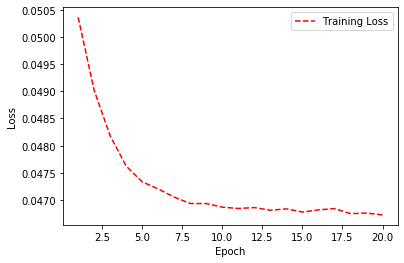

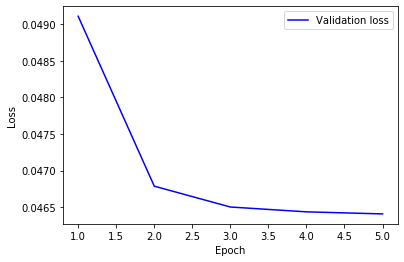

In [56]:
training(model, 20, state_dim=(NUM_LAYERS * DIRECTIONS, BATCH_SIZE, HIDDEN_SIZE))

In [0]:
|def training(model, epochs, state_dim, validate_every=10):
  
  for epoch in range(epochs):

      # Set to train mode
      model.train()

      # Initialize hidden and cell states with dimension:
      # (num_layers * num_directions, batch, hidden_size)
      states = (torch.zeros(state_dim).to(device), torch.zeros(state_dim).to(device))

      # Begin training
      for idx in range(num_batches["training"]):

          # Define range
          start = idx
          end = idx + SEQ_LENGTH * BATCH_SIZE
          x_window = x_train[start:end]
          y_window = y_train[start:end]
          
          # Convert to Tensors and modify dimensions
          x_tensor = torch.tensor(x_window.values).float()
          y_tensor = torch.tensor(y_window.values).float()
          x_batch = x_tensor.view(BATCH_SIZE, SEQ_LENGTH, NUM_FEATURES).to(device)
          y_batch = y_tensor.view(BATCH_SIZE, SEQ_LENGTH).unsqueeze(dim=2).to(device)

          optimizer.zero_grad()
          
          # Truncated Backpropagation 
          states = [state.detach() for state in states]          
          
          # Make prediction
          output, states = model(x_batch, states)

          loss = criterion(output, y_batch)
          loss.backward()
          # torch.nn.utils.clip_grad_norm(model.parameters(), 0.5)
          optimizer.step()

          print(f"Epoch {epoch+1}/{epochs}", 
                f"Index: {idx + 1}",
                f"Loss: {loss.item()}")

          # if epoch % validate_every == 0:

          #     # Set to eval mode
          #     model.eval()
          #     val_states = (torch.zeros(state_dim).to(device), torch.zeros(state_dim).to(device))
              
          #     for idx in range(num_batches["validation"]):

          #         start = idx
          #         end = idx + SEQ_LENGTH * BATCH_SIZE

          #         x_batch, y_batch = create_batches(x_val, y_val, start, end)
                
          #         # Detach states
          #         val_states = [state.detach() for state in val_states]

          #         output = model(data, val_states)

          #         val_loss = criterion(output, target)
          #         val_losses.append(val_loss.item())


          #         print(f"Epoch {epoch+1}/{epochs}", 
          #               f"Index: {idx + 1}",
          #               f"Loss: {loss.item()}",
          #               f"Validation Loss: {np.mean(val_losses)}")


In [0]:
training(model, 100, state_dim=(NUM_LAYERS * DIRECTIONS, BATCH_SIZE, HIDDEN_SIZE))

In [0]:
          start = idx
          end = idx + SEQ_LENGTH * BATCH_SIZE
          x_window = x_train[start:end]
          y_window = y_train[start:end]
          
          # Convert to Tensors and modify dimensions
          x_tensor = torch.tensor(x_window.values).float()
          y_tensor = torch.tensor(y_window.values).float()
          x_batch = x_tensor.view(BATCH_SIZE, SEQ_LENGTH, NUM_FEATURES).to(device)
          y_batch = y_tensor.view(BATCH_SIZE, SEQ_LENGTH).unsqueeze(dim=2).to(device)

In [0]:
print(len(test_data))

In [0]:
y_train[:90]

In [0]:
state_dim = (NUM_LAYERS * DIRECTIONS, BATCH_SIZE, HIDDEN_SIZE)

model.eval()
predictions = []
for idx in range(num_batches["testing"]):  
    with torch.no_grad():
      start = idx
      end = idx + SEQ_LENGTH * BATCH_SIZE
      x_window = x_test[start:end]
      y_window = y_test[start:end]

      # Convert to Tensors and modify dimensions
      x_tensor = torch.tensor(x_window.values).float()
      y_tensor = torch.tensor(y_window.values).float()
      x_batch = x_tensor.view(BATCH_SIZE, SEQ_LENGTH, NUM_FEATURES).to(device)
      y_batch = y_tensor.view(BATCH_SIZE, SEQ_LENGTH).unsqueeze(dim=2).to(device)  

      states = (torch.zeros(state_dim).to(device), torch.zeros(state_dim).to(device))
      results, states = model(x_batch, states)
      results = results.squeeze()[-1, -1]
      predictions.append(results)
      print("Appended")

In [0]:
|range(num_batches["training"])

In [0]:
predictions

In [0]:
state_dim = (NUM_LAYERS * DIRECTIONS, BATCH_SIZE, HIDDEN_SIZE)

def make_predictions(input, num_predictions):
  model.eval()
  predictions = []
  for i in range(num_predictions):
      with torch.no_grad():


        
          states = (torch.zeros(state_dim).to(device), torch.zeros(state_dim).to(device))
          predictions.append(model(input, states).item())
  return predictions

In [0]:
# note: batch normalization instead of general normalization

# Make 1 prediction

test_window = test_data[:SEQ_LENGTH]
test_tensor = torch.tensor(test_window.values).float()
test_batch = test_tensor.view(1, SEQ_LENGTH).to(device)
make_predictions(test_tensor, 1)

In [0]:
# https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction

def predict_sequences_multiple(model, data, window_size, prediction_len):
  prediction_seqs = []
  for i in range(int(len(data)/prediction_len)):
    curr_frame = data[i*prediction_len]
    predicted = []
    for j in range(prediction_len):
      predicted.append(model(curr_frame[newaxis,:,:])[0,0])
      curr_frame = curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    prediction_seqs.append(predicted)
  return prediction_seqs

In [0]:
with torch.no_grad():
  predict_sequences_multiple(model, y_test, SEQ_LENGTH, SEQ_LENGTH)